In [259]:
%matplotlib inline 
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from keras.models import Model, Sequential
from keras.layers import Input, Reshape, Dot, Dense, concatenate
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Add, Activation, Lambda


import matplotlib.pyplot as plt
%matplotlib inline
import csv

In [260]:
ratings = pd.read_csv("./movielens/ratings.csv")
ratings.shape

(100836, 4)

In [261]:
g = ratings.groupby ('userId') ['rating']. count () 
top_users = g.sort_values(ascending = False) [: 15] 
g = ratings.groupby ('movieId') ['rating']. count () 
top_movies = g.sort_values(ascending = False) [: 15] 
top_r = ratings.join (top_users, rsuffix = '_ r', how = 'inner', on = 'userId') 
top_r = top_r.join (top_movies, rsuffix = '_ r', how = 'inner', on = 'movieId') 
pd.crosstab (top_r.userId, top_r.movieId, top_r.rating, aggfunc = np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [262]:
#codifica degli utenti e risorse per evitare i salti tra IDs
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()


item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [263]:
ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


In [264]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)

In [265]:
#split train set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [266]:
X_train.shape, X_test.shape, X_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((72601, 2), (8067, 2), (20168, 2), (72601,), (8067,), (20168,))

In [267]:
n_factors = 50 
X_train_array = [X_train [:, 0], X_train [:, 1]] 
X_test_array = [X_test [:, 0], X_test [:, 1]]
X_validation_array = [X_validation [:, 0], X_validation [:, 1]]

In [268]:
X_validation_array

[array([275, 598, 482, ...,  81, 473,   5], dtype=int64),
 array([ 615, 4970, 1008, ..., 2248, 4561,  277], dtype=int64)]

In [280]:
user = Input(shape=(1,))
movie = Input(shape=(1,))
#first NN to user 
model_u = Sequential()
model_u.add(Embedding(n_users, n_factors, input_length=1))
model_u.add(Flatten())
model_u.add(Dense(30, activation='relu'))
model_u.add(Dense(10, activation='relu'))
#model_u.summary()

#second NN to item 
model_i = Sequential()
model_i.add(Embedding(n_movies, n_factors, input_length=1))
model_i.add(Flatten())
model_i.add(Dense(30, activation='relu'))
model_i.add(Dense(10, activation='relu'))
#model_i.summary()

combined = concatenate([model_u.output, model_i.output])
z = Dense(6, activation="softmax")(combined)
model = Model(inputs=[model_u.input,model_i.input], outputs=z)

In [281]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [282]:
history_1 = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=100,
                    verbose=0, validation_data=(X_validation_array, y_validation))

C:\Users\ricar\Anaconda3\envs\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


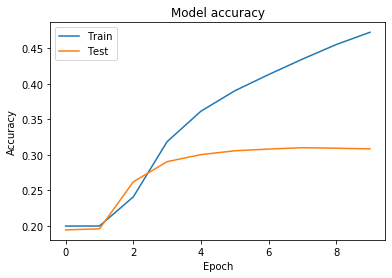

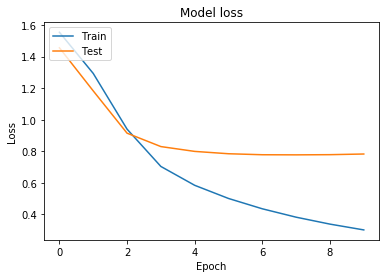

In [283]:
n_epochs=5
x_plot = list(range(1,n_epochs+1))
def plot_history(network_history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_history(history_1)

In [284]:
predict = model.predict(X_test_array)
prediction =[]
for i in predict:
    i=list(i)
    value=i.index(max(i))
    prediction.append(value)

In [293]:
print("prediction", "true_value")
for i in range(len(prediction)):
    print(prediction[i], y_test[i])

prediction true_value
4 4.5
3 3.0
3 4.0
4 5.0
3 3.5
4 4.5
3 3.5
3 2.5
3 2.0
3 3.0
5 4.5
5 4.0
3 5.0
3 3.0
3 2.5
3 4.0
5 5.0
3 1.5
4 3.5
3 2.5
3 4.0
3 3.0
4 3.0
3 2.5
4 4.5
5 4.0
3 4.0
3 4.5
5 5.0
5 5.0
3 3.0
4 1.0
4 3.0
5 4.5
4 3.0
3 1.0
5 5.0
5 2.0
3 5.0
3 3.5
3 2.0
3 5.0
4 5.0
5 4.0
3 3.5
3 3.0
5 3.0
2 2.0
3 4.0
4 5.0
3 2.5
2 3.0
3 3.0
3 3.0
4 4.5
1 2.0
3 4.0
4 4.5
4 1.5
4 4.0
3 3.0
3 4.0
3 4.5
3 4.0
4 5.0
4 4.5
3 3.5
5 2.0
1 3.0
3 2.0
4 4.5
4 2.0
5 5.0
3 4.0
4 4.0
4 1.0
3 3.0
5 4.0
3 2.0
3 4.0
3 4.0
4 5.0
4 3.5
3 3.5
3 3.0
3 4.0
3 4.0
1 5.0
4 4.0
0 2.0
3 2.5
3 3.5
3 3.0
4 4.0
4 5.0
3 2.0
5 5.0
4 4.0
4 3.5
4 5.0
3 3.0
3 4.0
5 3.0
3 2.0
3 4.0
4 4.5
4 3.0
3 2.5
5 2.0
4 5.0
4 4.0
4 3.0
2 1.5
4 4.0
3 3.5
3 3.5
4 3.5
2 3.0
3 4.5
4 1.5
4 4.0
4 2.0
3 3.0
3 5.0
4 4.0
3 3.5
4 4.5
4 4.0
3 4.0
4 3.5
2 3.0
4 4.0
2 4.0
4 2.0
5 3.5
3 3.0
3 3.5
4 4.0
4 4.5
4 3.0
4 4.0
4 3.0
3 4.5
5 5.0
4 4.0
3 4.5
3 4.5
4 4.5
4 2.0
4 3.0
5 5.0
3 3.5
3 4.0
4 3.0
3 4.5
5 4.0
4 4.0
3 3.0
4 5.0
2 3.0
4 4.0
2 3.0
3 4.0


3 1.0
4 4.0
1 1.5
4 2.5
4 5.0
4 4.0
3 5.0
5 2.0
4 2.0
3 4.5
3 4.0
3 4.0
3 3.0
3 4.0
4 5.0
3 3.5
4 3.0
3 4.0
4 3.0
4 5.0
3 3.0
3 3.0
4 4.5
3 3.0
4 2.0
4 4.0
5 4.0
4 2.5
3 4.0
3 4.0
3 3.5
3 3.0
2 3.0
5 3.0
4 4.0
4 3.0
3 4.0
3 3.0
2 1.0
4 3.5
3 2.5
3 2.5
4 2.0
3 3.5
2 1.0
3 4.0
4 3.5
5 4.5
4 4.0
2 2.0
3 4.0
3 3.0
3 3.0
4 3.0
4 4.5
3 1.0
4 4.0
2 3.5
3 3.0
3 3.5
5 5.0
4 4.5
4 4.0
4 4.0
2 3.0
3 1.0
1 1.0
3 3.0
4 3.0
2 2.0
3 3.0
5 2.0
4 4.0
4 2.5
5 3.0
1 1.0
4 4.5
3 4.0
4 3.0
3 3.0
4 4.0
4 5.0
3 2.0
3 4.0
3 3.0
4 4.0
4 2.5
4 3.5
3 4.5
3 3.5
4 4.0
3 4.0
2 2.0
4 3.0
4 5.0
3 3.0
5 4.0
3 5.0
3 2.0
4 4.0
4 3.0
3 3.0
3 3.5
4 4.0
5 4.0
3 4.5
4 4.0
4 3.0
4 4.0
3 3.0
5 4.0
3 3.5
4 3.5
3 3.0
4 4.0
3 3.0
4 2.0
4 3.0
5 5.0
3 2.0
4 4.0
2 2.0
2 1.0
4 3.0
3 3.5
4 3.5
3 1.5
3 3.0
3 3.0
5 5.0
4 2.0
3 2.0
3 3.0
2 3.5
4 1.0
3 4.0
5 5.0
4 1.0
3 5.0
4 4.0
2 1.0
4 3.5
3 4.0
3 3.0
4 5.0
3 4.0
3 1.0
4 3.0
3 4.5
4 3.0
3 4.0
5 5.0
4 3.0
4 4.0
4 4.0
4 5.0
5 4.0
4 4.0
4 4.0
3 4.0
3 2.0
3 1.5
5 5.0
4 4.0
3 1.0
3 4.0
2 0.

3 4.0
3 3.5
3 3.0
0 3.5
3 4.0
4 4.0
3 3.0
4 3.0
3 3.5
3 3.0
1 1.5
3 4.5
4 5.0
4 4.0
4 5.0
4 3.0
5 4.0
3 3.0
5 3.0
2 2.0
2 3.0
3 4.0
2 5.0
4 4.0
4 2.0
4 5.0
3 3.0
3 5.0
3 3.0
5 5.0
5 5.0
2 3.5
3 5.0
3 4.0
4 3.0
3 3.0
4 4.0
3 3.0
3 4.0
3 3.0
3 4.0
3 4.0
2 4.0
4 4.0
3 2.5
3 5.0
4 4.0
4 4.5
2 2.5
3 3.0
3 5.0
4 2.0
4 3.5
3 4.5
3 3.0
4 3.5
3 4.0
4 4.0
3 3.0
4 4.5
3 3.0
4 4.0
4 4.0
5 3.0
5 5.0
4 3.5
3 3.0
3 3.0
3 3.5
3 2.5
3 4.0
3 2.5
4 3.5
5 4.0
4 5.0
4 3.0
2 2.0
4 4.0
5 4.0
4 4.0
4 1.0
4 3.5
4 5.0
1 1.0
3 5.0
3 2.0
3 4.0
3 4.5
2 3.0
4 4.0
3 2.0
4 3.0
4 3.0
4 4.0
4 3.5
4 3.5
4 2.0
2 0.5
3 3.5
4 4.0
4 4.0
3 2.5
4 4.0
3 2.5
5 5.0
4 4.0
5 5.0
3 2.5
3 5.0
4 4.0
3 4.0
2 2.0
4 5.0
0 0.5
4 4.0
4 4.0
4 3.5
4 4.0
3 4.0
4 4.0
1 3.0
3 4.5
3 1.5
3 4.0
3 4.5
4 3.5
3 4.0
4 2.5
2 3.0
4 3.5
4 4.5
3 4.0
4 4.0
4 2.5
5 5.0
3 3.0
3 3.0
5 5.0
3 2.0
5 4.0
2 3.5
4 3.0
3 1.5
2 1.5
3 3.5
4 4.0
4 4.0
4 4.0
5 5.0
3 4.0
4 5.0
4 5.0
5 4.0
4 3.0
3 4.0
3 2.0
3 4.0
4 4.5
3 2.5
4 3.5
5 2.0
3 3.0
3 3.5
3 3.5
5 4.0
2 3.0
2 3.

2 2.0
3 4.0
4 5.0
3 3.0
3 3.0
3 3.0
4 3.5
1 4.0
4 4.0
1 3.5
3 3.5
3 2.0
4 4.0
5 4.0
3 3.0
3 1.0
4 4.5
4 3.5
3 4.0
5 5.0
4 3.0
5 4.0
4 4.5
4 3.0
5 5.0
2 2.5
4 5.0
3 3.5
3 3.0
4 3.0
4 3.5
4 3.0
4 4.0
5 5.0
4 3.0
3 4.0
3 3.5
1 2.5
3 3.0
3 3.5
1 0.5
4 3.0
3 4.0
3 3.5
3 2.0
5 5.0
4 5.0
5 5.0
3 3.5
4 4.0
2 2.5
3 1.5
3 3.0
3 4.0
3 4.0
3 3.5
3 3.5
4 3.0
1 5.0
4 4.5
4 3.0
4 5.0
3 3.0
2 3.0
3 3.5
4 4.5
3 4.5
5 4.0
3 4.0
4 3.5
4 5.0
4 4.0
5 5.0
3 4.0
4 4.5
3 3.0
4 4.5
4 4.0
3 3.5
3 2.0
2 3.5
3 4.0
4 5.0
3 3.0
1 3.0
2 5.0
4 3.0
5 5.0
2 3.0
4 2.5
4 4.0
4 4.0
4 1.0
4 5.0
4 3.0
3 2.5
3 2.0
4 3.5
3 3.0
4 3.0
4 4.5
3 4.5
3 1.0
4 4.0
3 3.5
4 2.0
3 3.0
5 5.0
5 4.5
4 5.0
4 4.0
3 2.0
3 2.0
4 4.0
3 3.0
4 5.0
3 2.0
1 2.0
5 5.0
3 4.0
5 5.0
5 5.0
3 4.5
2 2.0
5 5.0
4 4.0
4 2.5
2 3.0
2 5.0
3 3.0
4 2.0
3 2.0
4 3.5
3 2.0
4 4.0
5 5.0
3 1.0
4 3.5
3 3.5
4 3.0
3 2.0
1 2.0
3 3.0
2 3.0
1 5.0
2 2.5
3 4.0
5 3.0
3 3.5
3 3.0
4 3.0
2 2.0
2 3.0
3 2.0
2 2.0
3 5.0
4 4.0
5 5.0
3 1.5
3 3.0
4 4.0
1 2.5
4 4.0
3 3.5
3 3.0
4 5.0
3 3.

4 3.5
4 3.0
5 5.0
4 4.0
4 4.0
5 3.0
4 4.0
3 3.5
2 3.5
3 2.5
4 3.0
2 4.0
4 4.5
4 4.0
3 3.5
4 4.0
3 1.5
4 4.5
3 3.0
4 4.5
5 4.0
3 2.5
3 4.0
3 3.0
4 4.0
3 3.0
4 4.0
4 4.5
4 4.0
4 4.5
5 4.0
4 4.0
4 3.0
3 2.0
4 5.0
3 2.0
4 2.0
0 3.5
3 3.0
1 2.0
4 4.0
1 3.0
4 3.0
4 3.5
4 0.5
3 3.0
5 5.0
5 2.0
3 3.0
3 3.0
3 1.0
3 3.0
3 2.0
4 4.5
4 3.5
3 4.0
5 3.0
4 4.0
5 3.0
2 1.0
4 5.0
3 4.0
3 3.5
3 3.0
3 5.0
4 4.0
5 5.0
3 4.5
5 5.0
4 3.0
4 4.0
3 3.0
4 5.0
3 3.0
3 3.0
3 3.5
2 2.5
4 3.0
5 4.0
4 4.0
4 5.0
3 3.0
3 4.0
3 5.0
4 4.0
5 3.0
4 4.0
2 3.0
3 3.5
3 2.0
5 4.0
4 4.0
3 3.0
3 3.5
4 4.0
2 3.0
3 4.0
4 4.0
3 3.0
4 4.0
4 2.5
3 3.0
4 3.0
3 4.0
5 5.0
3 3.0
2 1.5
2 3.0
2 1.5
3 4.0
3 3.5
4 3.0
3 4.0
4 4.0
4 1.5
4 2.0
4 4.5
1 2.0
5 4.0
4 5.0
3 3.5
4 4.0
4 4.0
3 3.5
2 3.5
3 3.0
3 2.5
3 3.5
4 4.5
4 4.0
2 3.5
2 1.5
3 3.5
0 0.5
2 4.0
4 4.0
2 3.5
4 3.5
2 1.5
4 4.5
2 2.0
3 4.0
4 4.5
4 4.0
4 3.5
4 4.0
2 1.5
4 4.0
3 4.5
1 3.0
3 2.0
4 3.0
4 3.5
3 3.5
3 2.5
5 3.5
3 5.0
4 4.5
4 4.5
3 2.5
5 5.0
3 3.5
3 5.0
2 2.0
3 3.0
3 2.5
4 2.

In [286]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
def recommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    
    x = Dot(axes=1)([u, m])
  
    x = Add()([x, ub, mb])
    
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    #opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae','accuracy'])
    return model

In [287]:
model = recommenderV2 (n_users, n_movies, n_factors, min_rating, max_rating)

In [288]:
history = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=100,
                    verbose=0, validation_data=(X_validation_array, y_validation))

C:\Users\ricar\Anaconda3\envs\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


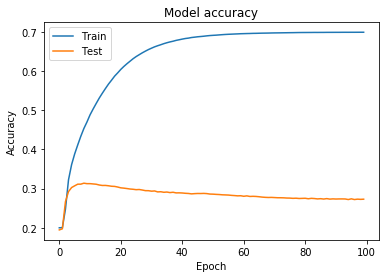

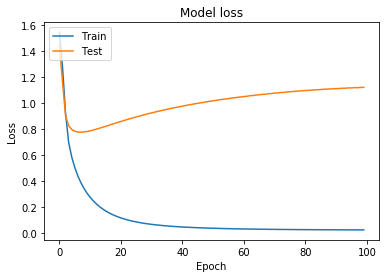

In [289]:
n_epochs=10
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

In [290]:
predict = model.predict(X_test_array)
rounded = [round(x[0],1) for x in predict]
predict_int= np.array(rounded,dtype='int64')

In [292]:
print("prediction", "true_value")
for i in range(len(prediction)):
    print(predict[i], y_test[i])

prediction true_value
[3.9985275] 4.5
[2.4040031] 3.0
[3.0167851] 4.0
[3.6855476] 5.0
[3.1736953] 3.5
[4.536783] 4.5
[4.362806] 3.5
[4.0595827] 2.5
[3.5713468] 2.0
[2.8967452] 3.0
[3.5757723] 4.5
[4.4398556] 4.0
[2.298729] 5.0
[2.5171075] 3.0
[2.7126424] 2.5
[3.2473989] 4.0
[3.1870086] 5.0
[2.6516845] 1.5
[2.9559865] 3.5
[2.4116716] 2.5
[3.9165583] 4.0
[2.9860206] 3.0
[2.9147408] 3.0
[2.92119] 2.5
[3.6510117] 4.5
[3.708514] 4.0
[3.5550592] 4.0
[3.4375618] 4.5
[4.9944468] 5.0
[4.9750204] 5.0
[2.974275] 3.0
[4.7563953] 1.0
[4.524988] 3.0
[4.57994] 4.5
[4.4656334] 3.0
[2.4258277] 1.0
[4.8847723] 5.0
[4.04212] 2.0
[3.2886915] 5.0
[4.4659185] 3.5
[3.5559554] 2.0
[3.3718405] 5.0
[3.5336876] 5.0
[4.6312637] 4.0
[2.9803934] 3.5
[3.1747227] 3.0
[4.7217264] 3.0
[2.2705178] 2.0
[3.6359203] 4.0
[2.1506243] 5.0
[3.3177452] 2.5
[3.4495478] 3.0
[2.758682] 3.0
[3.2476695] 3.0
[3.3004816] 4.5
[2.0297775] 2.0
[3.333395] 4.0
[3.8318515] 4.5
[3.5406017] 1.5
[3.2076287] 4.0
[4.1022196] 3.0
[1.8305144] 4.0


[2.8602455] 3.0
[1.1204408] 4.0
[4.0534725] 4.0
[4.9610806] 4.5
[3.218466] 4.5
[4.152055] 5.0
[3.183218] 4.0
[2.3588505] 2.0
[3.7403224] 3.5
[2.5290203] 3.0
[3.293286] 2.0
[2.3785505] 3.5
[1.2775848] 1.0
[3.8948069] 4.0
[2.5099812] 1.5
[4.3878117] 4.0
[2.8844671] 3.0
[4.960499] 5.0
[3.2728157] 3.5
[3.275705] 2.5
[2.8483894] 3.5
[2.996478] 4.0
[2.6168528] 2.0
[4.512946] 5.0
[3.3949666] 3.0
[4.1626277] 4.0
[3.4759989] 3.0
[3.9310436] 3.0
[2.6894114] 3.0
[1.3641417] 5.0
[3.194225] 4.0
[3.7288113] 3.0
[4.6717305] 5.0
[4.534704] 5.0
[4.057301] 4.5
[4.8725595] 1.0
[1.9663053] 3.5
[4.273446] 4.0
[2.8363302] 2.5
[3.0574894] 3.0
[2.848179] 4.0
[3.7412946] 3.5
[1.8659774] 2.0
[4.259301] 2.0
[4.1112337] 3.0
[4.6247635] 5.0
[4.8104763] 5.0
[4.466232] 4.0
[4.8081603] 4.0
[3.1252227] 3.0
[2.463078] 1.0
[3.714292] 2.5
[3.0415025] 1.0
[2.2100513] 3.0
[2.3803189] 2.5
[4.1895943] 4.0
[4.547529] 4.5
[3.5540977] 3.0
[4.8250484] 5.0
[4.2329617] 3.5
[4.2344794] 4.0
[3.7407258] 3.5
[4.7718444] 5.0
[4.5371337

[2.9303908] 3.0
[3.2749782] 3.0
[3.1132073] 3.0
[3.4630024] 4.0
[2.655179] 4.0
[2.6378422] 5.0
[4.019413] 4.0
[3.8266666] 4.0
[2.289742] 3.0
[3.5591645] 3.5
[2.330472] 5.0
[4.616548] 3.5
[3.1679497] 1.0
[2.849688] 2.0
[2.401723] 3.0
[3.722385] 4.0
[2.791748] 3.5
[4.2050123] 3.0
[3.1150172] 4.0
[4.7232313] 1.0
[3.5088737] 4.5
[2.179844] 3.0
[3.1122603] 4.0
[3.2786345] 5.0
[2.2349577] 4.0
[3.9161017] 4.0
[3.7663925] 4.0
[3.4556963] 4.0
[4.229785] 5.0
[4.9279766] 5.0
[2.6809032] 4.0
[2.7270274] 3.5
[4.1590447] 5.0
[3.3052404] 2.0
[2.3023071] 3.0
[4.073612] 4.0
[3.5546153] 4.0
[4.400662] 4.0
[1.6963964] 5.0
[4.342024] 2.5
[2.7348437] 3.0
[4.760661] 4.0
[3.6520631] 3.0
[2.3518734] 3.5
[1.4755671] 2.5
[4.5902286] 2.5
[4.911241] 4.5
[3.0847657] 3.5
[2.5547361] 3.5
[4.0781107] 5.0
[2.5636098] 3.0
[2.8388565] 2.5
[2.9890578] 2.0
[4.301508] 3.5
[4.6061506] 4.5
[3.5876954] 3.0
[3.0042999] 2.5
[4.922907] 5.0
[3.7332] 5.0
[4.8108773] 5.0
[2.8864465] 0.5
[1.6246871] 4.0
[3.6113083] 5.0
[4.5506086] 4

[4.5755153] 3.5
[3.9753683] 2.0
[4.1586533] 3.0
[4.7722406] 5.0
[4.6729817] 4.0
[4.2631226] 5.0
[3.0111082] 1.5
[4.8555894] 4.0
[2.9400387] 3.5
[2.743028] 2.0
[3.6144416] 2.0
[3.4260576] 4.0
[4.8281364] 5.0
[3.7682698] 4.0
[4.622243] 3.5
[3.495112] 3.5
[3.4011903] 2.5
[4.9078507] 5.0
[4.398445] 3.0
[4.9631276] 4.0
[4.4320416] 5.0
[2.9656749] 3.0
[4.4816284] 2.5
[3.0419755] 4.0
[4.786854] 4.5
[3.1748228] 3.0
[3.918297] 4.5
[3.6688375] 4.0
[3.8278987] 3.0
[2.8036451] 4.0
[2.3082476] 3.0
[3.148904] 1.5
[3.3026052] 3.5
[3.9108524] 5.0
[3.2378104] 3.5
[3.148904] 3.0
[3.2638838] 4.0
[4.4108624] 4.5
[3.1315613] 4.0
[2.6288497] 4.0
[3.4739308] 3.0
[4.2707915] 4.5
[3.6835315] 3.5
[2.8213997] 3.5
[2.8355336] 2.0
[3.1652625] 5.0
[3.108181] 4.5
[3.4803803] 3.5
[3.1151538] 4.0
[1.7822117] 3.0
[4.782744] 2.5
[2.525024] 4.0
[2.6571593] 3.0
[3.5560858] 3.0
[3.6750627] 4.0
[3.271511] 4.0
[2.603968] 3.0
[4.279568] 4.0
[3.3305693] 3.0
[3.6709704] 3.5
[3.0811772] 3.0
[4.1544027] 4.0
[3.932291] 4.0
[3.3756

[4.4889016] 4.0
[3.394571] 1.0
[3.954018] 3.5
[1.5346082] 4.5
[2.7005398] 2.5
[2.9138136] 5.0
[2.3641782] 3.5
[3.9143586] 4.5
[4.768053] 4.5
[4.9861145] 3.5
[3.5628629] 0.5
[2.6195307] 2.0
[4.447686] 3.5
[1.6835747] 2.0
[2.9120872] 3.0
[4.3660665] 3.0
[4.904486] 5.0
[2.3952506] 3.0
[2.3687062] 2.5
[4.533797] 2.0
[2.814412] 3.5
[4.2010617] 4.5
[4.1907887] 4.0
[4.860317] 4.0
[4.007909] 4.0
[4.346324] 4.5
[3.162766] 3.5
[2.7712822] 3.0
[4.347022] 4.0
[3.924033] 2.0
[3.6346655] 3.0
[3.5384512] 5.0
[3.6121428] 3.0
[4.0379] 3.0
[2.4944973] 3.0
[3.2974448] 4.0
[4.1548777] 4.0
[3.1648755] 3.0
[3.268233] 4.0
[3.0241156] 3.5
[4.6923585] 5.0
[2.1759057] 1.5
[4.558887] 4.5
[0.9060061] 3.0
[2.675069] 4.0
[3.063426] 3.0
[2.9644494] 4.0
[3.5724292] 4.5
[3.774414] 4.0
[3.01948] 2.5
[3.5850677] 3.5
[3.0119314] 3.0
[2.878037] 2.0
[3.8429627] 2.0
[2.276693] 3.0
[3.9838862] 4.0
[2.8887832] 5.0
[4.7359242] 5.0
[3.0130987] 3.0
[3.4739852] 4.0
[3.9826653] 4.0
[3.148904] 4.0
[4.318652] 3.0
[1.239346] 4.0
[3.1

[4.7806134] 4.0
[4.2591743] 4.5
[3.5128984] 4.0
[3.220865] 4.0
[3.412589] 4.0
[4.7027564] 4.5
[2.9478612] 3.0
[4.58387] 4.0
[4.4750156] 4.5
[3.1736622] 3.0
[4.4978514] 3.0
[2.7464025] 3.5
[4.052663] 4.5
[2.9436154] 2.0
[4.6970024] 5.0
[4.248629] 3.5
[2.5331366] 3.5
[2.8900328] 3.0
[3.073006] 3.0
[3.8112288] 5.0
[4.4331965] 4.5
[2.3846302] 2.5
[4.556409] 5.0
[3.4110167] 3.0
[1.4362639] 3.5
[4.286414] 3.0
[3.9969363] 3.0
[4.9338603] 3.5
[3.8893123] 3.0
[4.9043694] 4.0
[1.5561192] 3.0
[4.1813517] 0.5
[4.480858] 5.0
[2.5743499] 2.5
[3.4565125] 4.5
[3.144036] 3.0
[4.221426] 5.0
[3.4150274] 4.5
[2.333663] 2.0
[4.871859] 3.5
[3.0645976] 5.0
[3.0472791] 4.0
[4.680664] 4.5
[1.7661033] 4.0
[4.4250317] 4.5
[4.771034] 5.0
[2.7578595] 2.0
[4.7950625] 4.5
[2.6879725] 3.5
[4.100553] 4.0
[1.8841616] 3.0
[3.136367] 2.0
[1.1348097] 0.5
[1.9616126] 0.5
[2.7683504] 3.5
[1.1865337] 3.0
[3.6289642] 4.0
[2.3795033] 4.0
[3.9859598] 4.5
[4.401784] 4.5
[3.6668358] 4.5
[4.1795893] 3.0
[4.0218053] 3.5
[3.664247] 

[2.711513] 0.5
[4.448785] 5.0
[4.091483] 4.0
[1.4942348] 1.0
[3.014636] 3.0
[3.622519] 4.0
[4.7537465] 5.0
[4.118314] 3.5
[3.7912307] 1.0
[4.0425444] 3.0
[3.4803934] 2.0
[4.622793] 4.5
[4.3624086] 3.5
[2.6931882] 3.5
[3.594215] 3.0
[2.994637] 2.0
[3.2544565] 3.0
[4.447554] 4.5
[2.204824] 2.0
[1.7816858] 2.5
[1.027233] 2.0
[3.9019916] 3.5
[2.4958897] 3.0
[3.2871633] 4.0
[2.4747517] 4.5
[2.900953] 4.0
[3.2420723] 3.0
[3.1122603] 3.0
[1.9459682] 5.0
[4.385873] 3.5
[3.2465754] 3.5
[4.8056293] 4.0
[4.1976247] 3.0
[4.602553] 3.5
[4.540468] 3.0
[2.1072395] 2.5
[4.14634] 2.5
[1.3823736] 2.0
[4.9806757] 5.0
[4.484665] 5.0
[3.479434] 4.0
[3.354425] 2.5
[4.4328156] 2.0
[3.6966062] 3.0
[4.497343] 5.0
[3.1173475] 3.0
[3.2332394] 3.5
[4.4165163] 5.0
[2.1910973] 3.0
[2.6894114] 2.5
[2.3273845] 2.5
[3.1085927] 2.0
[1.7391136] 3.0
[4.8522253] 4.0
[4.580456] 4.0
[3.1151958] 4.0
[3.2420485] 3.0
[4.7843585] 4.0
[3.5521998] 1.5
[4.892651] 4.5
[4.313341] 4.0
[3.449884] 4.0
[3.08316] 4.0
[3.786817] 4.0
[3.19

[4.1736746] 3.5
[3.6954784] 1.5
[4.338172] 3.0
[4.870772] 4.0
[3.0872507] 3.0
[2.796035] 4.5
[3.3110738] 2.5
[4.3229904] 4.0
[2.4005418] 3.0
[2.9810696] 4.0
[2.9217765] 3.0
[3.7351725] 3.0
[3.0519454] 5.0
[2.272475] 3.0
[2.1072288] 2.0
[3.9616082] 4.0
[4.391905] 4.0
[4.3758154] 3.0
[3.4486701] 4.5
[3.0473583] 3.5
[1.534641] 3.0
[4.8377867] 5.0
[2.5845864] 3.5
[4.233718] 3.0
[3.4921646] 3.0
[3.034031] 2.5
[4.5612288] 3.0
[1.5343297] 4.0
[3.4457529] 4.0
[3.7954156] 3.5
[3.7614229] 4.0
[4.2163124] 4.0
[4.7379136] 5.0
[3.93088] 3.5
[1.7307374] 3.0
[1.4891311] 3.0
[2.4983125] 3.0
[3.58662] 1.0
[2.2516885] 2.0
[4.8114944] 5.0
[3.9910488] 4.0
[2.5241244] 4.0
[3.52995] 2.5
[3.5483005] 4.0
[3.6831555] 4.0
[4.6660633] 5.0
[2.825006] 5.0
[3.586564] 4.0
[4.7304673] 4.0
[4.373784] 4.0
[3.213198] 2.0
[2.34856] 3.5
[3.7455332] 4.5
[3.193089] 3.5
[2.115446] 3.0
[3.8134484] 4.0
[3.8221397] 2.0
[4.6189895] 5.0
[4.0242243] 2.5
[2.9590507] 2.0
[4.2099667] 4.5
[3.4451551] 5.0
[1.1364022] 3.5
[4.463505] 4.0

[3.7297828] 4.0
[4.3967237] 4.0
[4.1906915] 4.0
[4.8800735] 4.5
[3.5919116] 5.0
[4.3058825] 4.5
[4.341205] 5.0
[3.7334375] 4.0
[1.5988644] 3.0
[4.266383] 3.0
[2.9384902] 4.0
[4.6215606] 5.0
[2.9383335] 2.0
[4.9882975] 4.0
[4.13466] 2.0
[4.908344] 4.0
[4.3566685] 3.5
[2.910791] 3.5
[3.724859] 3.0
[3.6571403] 2.0
[3.777784] 3.5
[2.9900794] 3.5
[4.8444695] 5.0
[2.4784427] 2.0
[2.7047558] 2.0
[3.4415264] 3.5
[4.061523] 3.0
[3.4588957] 3.0
[3.0785553] 2.0
[2.8913999] 3.5
[3.080494] 4.0
[4.3514194] 4.0
[3.5062473] 4.0
[3.5285625] 5.0
[3.0471222] 3.5
[3.5955672] 2.5
[2.3583322] 3.0
[4.4302397] 4.5
[4.396731] 4.0
[2.0667825] 2.5
[2.6910524] 5.0
[2.6322856] 2.5
[2.68497] 4.0
[2.854018] 3.0
[4.4357557] 5.0
[3.9071734] 5.0
[3.37651] 3.0
[2.2030585] 3.5
[3.764278] 4.0
[2.6868677] 4.0
[3.1042926] 5.0
[3.2750258] 3.5
[2.9559643] 3.5
[2.654786] 4.5
[2.9658945] 1.0
[3.8212695] 3.5
[3.5926857] 3.5
[4.012162] 5.0
[4.2713375] 4.0
[4.2237244] 5.0
[4.4716926] 4.0
[3.3044364] 4.0
[1.8970473] 2.0
[3.1054244]

[2.5484967] 3.5
[4.5544953] 5.0
[2.5995898] 4.5
[4.5800414] 4.0
[3.551379] 5.0
[4.7048817] 3.0
[3.254632] 3.0
[3.9459429] 3.5
[4.4172564] 4.0
[2.5167804] 3.0
[4.535078] 4.0
[2.285848] 3.5
[2.7289312] 2.0
[2.5049314] 4.0
[4.794119] 5.0
[4.3082395] 3.0
[3.2434464] 4.0
[4.0598183] 4.5
[3.3907857] 4.0
[4.5634727] 4.0
[4.9175987] 4.5
[3.7472215] 3.5
[4.5487576] 5.0
[3.6165566] 3.0
[2.6409464] 2.0
[2.5160713] 2.0
[3.0964694] 4.0
[4.9252505] 5.0
[3.2199101] 5.0
[2.5331366] 2.0
[3.944858] 3.5
[3.2000277] 3.0
[4.407699] 4.0
[1.9453253] 1.0
[2.79957] 4.0
[2.0294561] 5.0
[3.082025] 4.0
[2.6719115] 2.5
[3.8021142] 3.0
[4.814169] 5.0
[2.9350536] 4.0
[3.1999617] 4.0
[4.0972533] 2.0
[3.3399122] 3.5
[3.1451004] 1.5
[3.302965] 3.0
[4.0874662] 4.0
[4.256468] 2.5
[2.1379304] 1.5
[1.977073] 3.0
[3.9581254] 4.5
[4.987065] 2.0
[3.2886915] 3.5
[3.9206212] 1.5
[2.5268574] 2.5
[3.7550368] 5.0
[1.5674939] 5.0
[4.545886] 3.0
[2.506877] 3.5
[3.933522] 2.5
[3.7371292] 4.0
[3.2733774] 3.0
[4.9286065] 5.0
[4.821994]

[3.3467505] 4.0
[2.5254753] 2.0
[4.3555107] 3.0
[4.4908776] 4.0
[2.8383515] 4.0
[2.4240315] 3.0
[1.558069] 2.5
[4.4369526] 4.0
[4.102376] 4.0
[3.1298132] 4.0
[3.6544187] 3.0
[3.1629233] 4.0
[3.5378532] 4.0
[2.8817692] 4.0
[2.9364834] 4.0
[4.1273746] 4.0
[4.9466224] 5.0
[3.4443736] 1.0
[2.4136395] 5.0
[2.6894114] 3.5
[3.7363026] 3.0
[3.7948308] 3.0
[3.8323073] 5.0
[3.3100924] 5.0
[4.367768] 3.5
[4.3473444] 4.0
[3.1953855] 4.0
[3.3808956] 2.0
[4.8679566] 5.0
[1.9918702] 4.0
[3.193089] 3.0
[3.0224721] 3.0
[3.7480388] 3.5
[3.107902] 4.0
[3.5873947] 4.0
[3.384494] 4.0
[3.7568803] 4.5
[2.5552118] 4.0
[3.299805] 2.0
[3.076015] 4.5
[4.2214994] 4.5
[2.5390537] 3.0
[3.9091473] 4.0
[4.4578366] 4.0
[3.0283554] 2.0
[3.536718] 4.5
[4.0710135] 2.5
[3.7304072] 3.0
[1.4643836] 0.5
[4.777327] 3.5
[4.3834887] 3.0
[1.830855] 1.0
[3.8794475] 4.0
[4.617186] 5.0
[3.7148647] 4.0
[4.404712] 2.5
[3.573399] 5.0
[2.494276] 2.0
[0.96177167] 3.0
[3.9007902] 3.0
[4.491847] 2.5
[2.7476337] 3.0
[3.2362685] 4.5
[4.3681

[4.4462166] 4.0
[4.155568] 4.0
[3.450686] 2.0
[3.7536402] 4.0
[3.034605] 5.0
[3.7725465] 4.0
[3.075515] 3.0
[2.9740303] 3.0
[3.8575644] 4.0
[3.6535392] 4.0
[2.39222] 4.0
[3.7748554] 3.0
[3.1920753] 2.5
[3.7087398] 4.0
[2.6447175] 4.0
[1.8240108] 4.0
[3.2013726] 3.0
[4.3920865] 4.5
[4.6182737] 5.0
[1.6368304] 1.0
[3.0984256] 3.5
[1.9775608] 2.5
[1.9442998] 5.0
[2.0924816] 3.5
[3.3620603] 4.0
[4.005965] 3.5
[3.809855] 4.0
[3.6802335] 4.0
[3.1006052] 4.0
[3.7546105] 3.0
[3.7307932] 5.0
[4.831464] 4.0
[4.6490884] 4.0
[2.297171] 4.0
[3.5620244] 3.5
[2.8375015] 3.0
[2.6823542] 3.0
[4.2601495] 4.0
[3.2657866] 3.0
[4.712695] 4.0
[2.007934] 2.0
[3.028383] 4.0
[3.404633] 2.0
[3.1095939] 4.0
[3.3934805] 3.0
[2.6437755] 3.0
[4.88676] 5.0
[3.148904] 3.5
[2.4976587] 1.5
[4.2376823] 4.0
[2.6553555] 3.5
[3.4772224] 4.0
[3.2498088] 4.0
[3.0781314] 4.0
[4.289866] 3.0
[2.6087534] 4.0
[2.8216255] 2.5
[2.9552085] 3.5
[4.161935] 4.5
[4.5220575] 1.0
[2.461796] 4.0
[2.4764524] 3.0
[2.746297] 3.0
[3.1389782] 4

[3.4162478] 4.5
[4.10631] 2.5
[3.9074178] 4.0
[3.4308167] 4.5
[4.0258493] 4.0
[3.436639] 4.5
[4.381084] 4.0
[3.5745428] 1.0
[4.0920725] 5.0
[2.2099152] 3.0
[3.302154] 4.0
[3.244623] 1.0
[3.7022612] 5.0
[4.9422235] 4.0
[3.0024831] 4.0
[4.9721446] 5.0
[2.8420384] 2.5
[2.8146768] 4.0
[2.4019284] 2.5
[2.485689] 4.0
[3.4511619] 4.0
[3.2470064] 2.0
[4.994667] 5.0
[3.5151196] 4.0
[4.8607903] 4.0
[3.1822622] 3.5
[2.873258] 3.5
[3.298817] 4.0
[3.9280481] 4.0
[2.9419048] 2.0
[4.597009] 4.0
[1.9524207] 3.5
[3.653127] 4.0
[3.0012257] 4.0
[2.9695606] 5.0
[4.2229433] 3.0
[2.5495138] 2.0
[1.1833947] 4.0
[4.106087] 2.5
[2.302196] 2.0
[3.3723304] 4.5
[2.908713] 2.5
[3.8825288] 5.0
[3.6882567] 1.0
[1.8304083] 4.0
[3.0942047] 4.0
[4.2959924] 3.0
[3.9472506] 4.0
[3.6095004] 4.0
[4.587393] 4.5
[3.8820946] 3.0
[3.330572] 4.5
[3.9313872] 4.5
[4.1841164] 3.5
[2.3115149] 3.0
[3.9086208] 3.0
[3.2663877] 4.0
[1.3512735] 3.5
[1.712841] 3.0
[1.45726] 4.0
[2.4109843] 2.0
[3.614442] 4.0
[4.4979963] 3.0
[1.5336837] 4

[2.593885] 3.0
[2.362554] 2.5
[3.649268] 3.5
[4.938963] 4.5
[4.146006] 4.0
[2.9121928] 3.5
[2.6435697] 1.5
[2.3978562] 3.5
[4.608885] 0.5
[2.459879] 4.0
[3.2134323] 4.0
[3.7145581] 3.5
[3.8531122] 3.5
[2.1441479] 1.5
[4.0292044] 4.5
[2.8765056] 2.0
[3.8161457] 4.0
[3.6584723] 4.5
[3.7600198] 4.0
[3.8788562] 3.5
[4.271226] 4.0
[2.0192604] 1.5
[3.9213011] 4.0
[3.167168] 4.5
[3.372893] 3.0
[2.695728] 2.0
[3.7898178] 3.0
[3.9517717] 3.5
[3.0111082] 3.5
[2.607253] 2.5
[4.929233] 3.5
[4.0588183] 5.0
[4.6938324] 4.5
[3.859847] 4.5
[2.4484596] 2.5
[4.924485] 5.0
[3.2030187] 3.5
[3.2678862] 5.0
[2.789835] 2.0
[3.7483983] 3.0
[3.1191494] 2.5
[3.4538348] 2.0
[2.8022814] 2.0
[3.586512] 0.5
[3.193089] 3.5
[3.721716] 4.0
[4.8037534] 5.0
[1.8066816] 3.5
[3.2138429] 4.0
[3.5294962] 4.0
[3.8117552] 3.0
[2.8374028] 1.5
[3.398631] 3.0
[3.3387814] 3.0
[3.467068] 3.5
[2.649837] 2.0
[3.6363316] 3.0
[2.6262908] 2.0
[2.3887715] 3.0
[3.2603064] 5.0
[4.907035] 3.0
[2.9724195] 1.5
[4.762439] 4.0
[3.4330285] 2.0


[4.297023] 4.0
[1.8596319] 3.0
[4.269998] 4.0
[1.8684139] 4.0
[2.2130127] 2.5
[4.427352] 1.0
[2.995915] 3.0
[2.689278] 4.0
[3.407395] 3.0
[2.8170729] 4.0
[4.3464174] 4.5
[4.041405] 3.0
[4.2834735] 4.0
[4.614059] 5.0
[4.8890543] 5.0
[2.9053786] 2.5
[4.0240393] 2.5
[4.1740127] 3.0
[4.2766504] 3.0
[3.8366396] 3.5
[2.6894114] 1.5
[1.3209288] 1.0
[2.5475874] 4.0
[3.1464503] 3.0
[2.5035295] 2.0
[4.2594557] 4.5
[3.6251135] 3.0
[3.457612] 3.0
[4.6975656] 5.0
[1.5296097] 2.5
[2.1664913] 3.0
[3.4088871] 3.5
[2.3101811] 1.5
[1.88096] 5.0
[3.017541] 3.0
[4.6378646] 4.5
[1.4629143] 4.0
[2.240695] 4.0
[3.0568297] 3.0
[3.6152394] 3.0
[2.8978286] 5.0
[3.8527074] 4.0
[2.8044057] 4.0
[3.0050733] 4.0
[4.3603573] 4.0
[4.555562] 5.0
[3.6859152] 4.5
[2.6493351] 4.5
[3.0507388] 4.0
[3.7857313] 4.0
[4.0315585] 3.5
[4.455468] 4.0
[3.0111082] 4.0
[1.8530427] 2.5
[4.7208595] 4.0
[3.1264653] 3.0
[3.6828294] 5.0
[3.2527552] 3.5
[4.0533757] 2.5
[3.4321606] 3.0
[4.6280093] 5.0
[4.65236] 4.5
[1.2524508] 1.0
[4.285447